In [1]:
import torch
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
from cvxpylayers.torch import CvxpyLayer
from scipy.linalg import solve_discrete_are
# from extquadcontrol import lqr_average
from PIL import Image
import matplotlib as mpl
from utils import latexify

torch.set_default_dtype(torch.float32)

In [9]:
L = 2.8
h = .2
n = 6
m = 2

lam_1 = 1
lam_2 = 1
lam_3 = 10
lam_4 = 10

k = 555

In [4]:
def plot_path(X, title="plot", kolor='b'):
    E, N, psi = np.zeros(1), np.zeros(1), np.ones(1)*np.pi/2
    E_veh, N_veh = [np.zeros(1)]*2 
    ds = X[-1,0] / 100

    for s in np.linspace(0, X[-1,0], 100):
        e = np.interp(s, X[:, 0], X[:, 1]) # X[:, 1] = f(X[:, 0]), e = X[:, 1] @ s
        dpsi = np.interp(s, X[:, 0], X[:, 2]) # X[:, 2] = f(X[:, 0]), dpsi = X[:, 2] @ s

        t = mpl.markers.MarkerStyle(marker=9)
        t._transform = t.get_transform().rotate_deg(np.rad2deg(-psi[-1]- dpsi + np.pi/2))
        
        plt.scatter((E_veh[-1],), (N_veh[-1],), s=3, c=kolor, marker=t, alpha=.5)

        E_veh = np.append(E_veh, E[-1] - e * np.sin(psi[-1]))
        N_veh = np.append(N_veh, N[-1] + e * np.cos(psi[-1]))

        E = np.append(E, E[-1] + ds * np.sin(psi[-1]))
        N = np.append(N, N[-1] + ds * np.cos(psi[-1]))

        curvature_at_s = np.interp(s, X[:, 0], X[:, -1])
        
        psi = np.append(psi, psi[-1] + ds * curvature_at_s)

    plt.plot(E, N, c='r', linewidth=1)
    extent = max(np.max(E) - np.min(E) + 2, np.max(N) - np.min(N) + 2)
    E_middle = .5 * (np.max(E) + np.min(E))
    N_middle = .5 * (np.max(N) + np.min(N))
    plt.xlim(E_middle - extent/2, E_middle + extent/2)
    plt.ylim(N_middle - extent/2, N_middle + extent/2)
    plt.title(title)

In [5]:
# approximate value function
P_sqrt = cp.Parameter((4, 4))
q = cp.Parameter(4)

# dynamics
fx = cp.Parameter(4)
B = cp.Parameter((4, 2))
curvature = cp.Parameter(1)

u = cp.Variable(2)
y = cp.Variable(4)

a = u[0]
z = u[1]

objective = lam_3 * cp.square(a) + lam_4 * cp.square(z) + \
    cp.sum_squares(P_sqrt @ y) + q @ y # ADP approximate value function \hat{V}(f(x))
constraints = [
    y == fx + B @ u,
    cp.abs(a) <= 2,
    cp.abs(z + L * curvature) <= .68 # max wheel angle magnitude
]
prob = cp.Problem(cp.Minimize(objective), constraints)
policy = CvxpyLayer(prob, [P_sqrt, q, fx, B, curvature], [u])

In [13]:
def split_state_control(x, u):
    assert x.ndim == 2
    assert u.ndim == 2
    assert x.shape[0] == u.shape[0]
    assert x.shape[1] == n
    assert u.shape[1] == m
    
    # 0: s, parameterization of point along path
    # 1: e
    # 2: dpsi
    # 3: v
    # 4: vdes
    # 5: curvature

    return x[:, 0], x[:, 1], x[:, 2], x[:, 3], x[:, 4], x[:, 5], u[:, 0], u[:, 1]

def f_batch0(x, u):
    s, e, dpsi, v, vdes, curvature, a, z = split_state_control(x, u)
    
    curvatures_to_not_change = torch.rand_like(curvature) < .95 # change on average every 4 seconds
    curvature_next = curvatures_to_not_change * curvature + \
        ~curvatures_to_not_change * .1 * torch.randn_like(curvature)
    
#     curvature_next = torch.zeros_like(curvature)
#     # print("s", s)
#     curvature_next[s > 10] = 0.1

#     vdes_to_not_change = torch.rand_like(vdes) < .98 # change on average every 10 seconds
#     vdes_next = vdes_to_not_change * vdes +\
#         ~vdes_to_not_change * torch.distributions.Uniform(3, 6).sample(sample_shape=vdes.shape)
    vdes_next = vdes

    xnext = torch.stack([
        # some kinematics
        s + h * v / (1 - e * curvature) * torch.cos(dpsi),
        e + h * v * torch.sin(dpsi),
        dpsi + h * v * (curvature + z / L - curvature / (1 - e * curvature) * torch.cos(dpsi)),
        v + h * a,

        vdes_next,
        curvature_next
    ], dim=1)
    
    xnext[:, 1] += 1e-1*torch.randn(x.shape[0]) # w_1, noise on lateral path deviation
    xnext[:, 2] += 1e-2*torch.randn(x.shape[0]) # w_2, noise on heading deviation
    xnext[:, 3] += 1e-1*torch.randn(x.shape[0]) # w_3 noise on velocity
    
    return xnext

def f_batch(x, u):
    s, e, dpsi, v, vdes, curvature, a, z = split_state_control(x, u)
    
    curvatures_to_not_change = torch.rand_like(curvature) < .95 # change on average every 4 seconds
    curvature_next = curvatures_to_not_change * curvature + \
        ~curvatures_to_not_change * .1 * torch.randn_like(curvature)
    
    curvature_next = torch.zeros_like(curvature)
    # print("s", s)
    curvature_next[s > 10] = 0.1

#     vdes_to_not_change = torch.rand_like(vdes) < .98 # change on average every 10 seconds
#     vdes_next = vdes_to_not_change * vdes +\
#         ~vdes_to_not_change * torch.distributions.Uniform(3, 6).sample(sample_shape=vdes.shape)
    vdes_next = vdes

    xnext = torch.stack([
        # some kinematics
        s + h * v / (1 - e * curvature) * torch.cos(dpsi),
        e + h * v * torch.sin(dpsi),
        dpsi + h * v * (curvature + z / L - curvature / (1 - e * curvature) * torch.cos(dpsi)),
        v + h * a,

        vdes_next,
        curvature_next
    ], dim=1)
    
    xnext[:, 1] += 1e-1*torch.randn(x.shape[0]) # w_1, noise on lateral path deviation
    xnext[:, 2] += 1e-2*torch.randn(x.shape[0]) # w_2, noise on heading deviation
    xnext[:, 3] += 1e-1*torch.randn(x.shape[0]) # w_3 noise on velocity
    
    return xnext

def f_batch2(x, u):
    s, e, dpsi, v, vdes, curvature, a, z = split_state_control(x, u)
    
    curvatures_to_not_change = torch.rand_like(curvature) < .95 # change on average every 4 seconds
    curvature_next = curvatures_to_not_change * curvature + \
        ~curvatures_to_not_change * .1 * torch.randn_like(curvature)
    
    curvature_next = torch.zeros_like(curvature)
    # print("s", s)
    curvature_next[s > 10] = -0.1

#     vdes_to_not_change = torch.rand_like(vdes) < .98 # change on average every 10 seconds
#     vdes_next = vdes_to_not_change * vdes +\
#         ~vdes_to_not_change * torch.distributions.Uniform(3, 6).sample(sample_shape=vdes.shape)
    vdes_next = vdes

    xnext = torch.stack([
        # some kinematics
        s + h * v / (1 - e * curvature) * torch.cos(dpsi),
        e + h * v * torch.sin(dpsi),
        dpsi + h * v * (curvature + z / L - curvature / (1 - e * curvature) * torch.cos(dpsi)),
        v + h * a,

        vdes_next,
        curvature_next
    ], dim=1)
    
    xnext[:, 1] += 1e-1*torch.randn(x.shape[0]) # w_1, noise on lateral path deviation
    xnext[:, 2] += 1e-2*torch.randn(x.shape[0]) # w_2, noise on heading deviation
    xnext[:, 3] += 1e-1*torch.randn(x.shape[0]) # w_3 noise on velocity
    
    return xnext

def f_batch3(x, u):
    s, e, dpsi, v, vdes, curvature, a, z = split_state_control(x, u)
    
    curvatures_to_not_change = torch.rand_like(curvature) < .95 # change on average every 4 seconds
    curvature_next = curvatures_to_not_change * curvature + \
        ~curvatures_to_not_change * .1 * torch.randn_like(curvature)
    
    curvature_next = torch.zeros_like(curvature)
    # print("s", s)
#     curvature_next[s > 10] = -0.1

#     vdes_to_not_change = torch.rand_like(vdes) < .98 # change on average every 10 seconds
#     vdes_next = vdes_to_not_change * vdes +\
#         ~vdes_to_not_change * torch.distributions.Uniform(3, 6).sample(sample_shape=vdes.shape)
    vdes_next = vdes

    xnext = torch.stack([
        # some kinematics
        s + h * v / (1 - e * curvature) * torch.cos(dpsi),
        e + h * v * torch.sin(dpsi),
        dpsi + h * v * (curvature + z / L - curvature / (1 - e * curvature) * torch.cos(dpsi)),
        v + h * a,

        vdes_next,
        curvature_next
    ], dim=1)
    
    xnext[:, 1] += 1e-1*torch.randn(x.shape[0]) # w_1, noise on lateral path deviation
    xnext[:, 2] += 1e-2*torch.randn(x.shape[0]) # w_2, noise on heading deviation
    xnext[:, 3] += 1e-1*torch.randn(x.shape[0]) # w_3 noise on velocity
    
    return xnext

def cost_batch(x, u):
    s, e, dpsi, v, vdes, curvature, a, z = split_state_control(x, u)

    return (v - vdes).pow(2) + lam_1 * e.pow(2) + lam_2 * dpsi.pow(2) + \
        lam_3 * a.pow(2) + lam_4 * z.pow(2)

def loss(time_horizon, batch_size, P_sqrt, q, seed=None, f_func=f_batch):
    if seed is not None:
        torch.manual_seed(seed)
    X, U = [], []
    
    # 0: s, parameterization of point along path
    # 1: e
    # 2: dpsi
    # 3: v
    # 4: vdes
    # 5: curvature
    x = torch.zeros(batch_size, n)
    x[:, 1] = .5
    x[:, 2] = .1
    x[:, 3] = 3
    x[:, 4] = 4.5

    loss = 0.0
    for _ in range(time_horizon):
        # there are batch_size states in this 'batch'
    
        _, e, dpsi, v, vdes, curvature, _, _ = split_state_control(x, torch.zeros(batch_size, 2))

        # kinematics for x
        enext = e + h * v * torch.sin(dpsi)
        dpsi_next = dpsi + h * v * (curvature - curvature / (1 - e * curvature) * torch.cos(dpsi))

        fx = torch.stack([
                enext,
                dpsi_next,
                v - .98*vdes-.02*4.5, # vdes
                enext + h * v * torch.sin(dpsi_next) # kappa_next
            ], dim=1).to(torch.float32)

        # kinematics for u
        B = torch.zeros(batch_size, 4, 2, dtype=torch.float32)
        B[:, 1, 1] = h * v / L
        B[:, 2, 0] = h
        B[:, 3, 1] = h * h * v * v / L

        u, = policy(P_sqrt, q, fx, B,
            curvature.to(torch.float32).unsqueeze(-1),
            solver_args={"acceleration_lookback": 0})

        loss += cost_batch(x, u).mean() / time_horizon

        X.append(x.detach().numpy().squeeze())
        U.append(u.detach().numpy().squeeze())

        x = f_func(x, u)
    return loss, np.array(X), np.array(U)

In [14]:
P_sqrt = torch.eye(4, dtype=torch.float32)
P_sqrt.requires_grad_(True)
q = torch.zeros(4, requires_grad=True, dtype=torch.float32)

k 0
it: 001, loss: 2.517


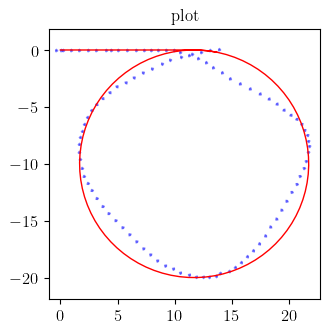

k 1
it: 002, loss: 2.380


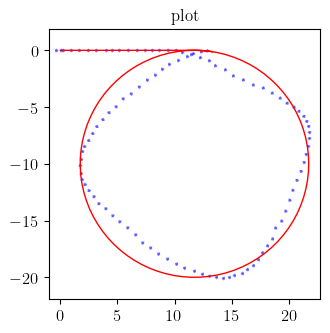

k 2
it: 003, loss: 2.314


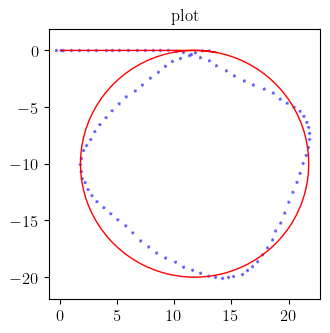

k 3
it: 004, loss: 2.020


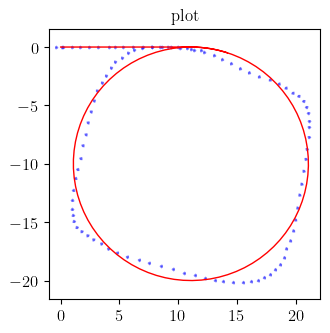

k 4
it: 005, loss: 2.000


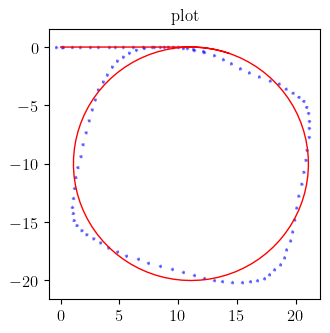

k 5
it: 006, loss: 1.415


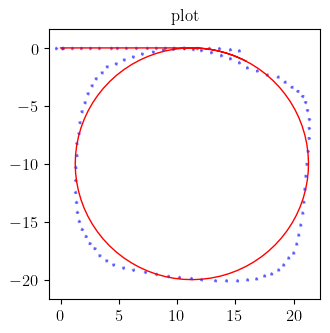

k 6
it: 007, loss: 1.229


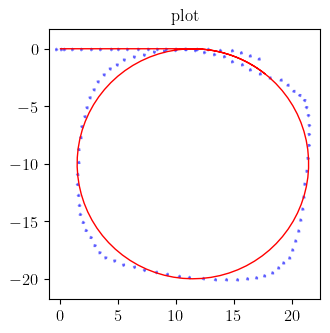

k 7
it: 008, loss: 1.150


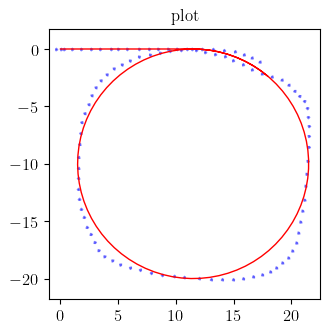

k 8
it: 009, loss: 1.119


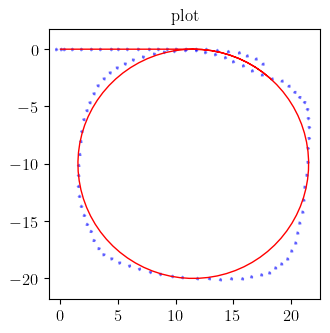

k 9
it: 010, loss: 1.093


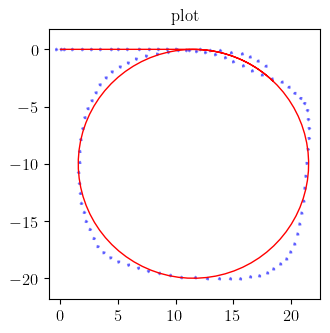

k 10
it: 011, loss: 1.038


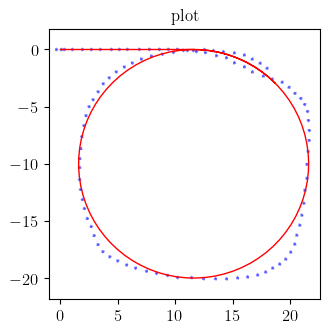

k 11
it: 012, loss: 1.014


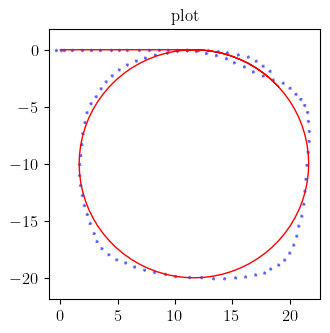

k 12
it: 013, loss: 0.993


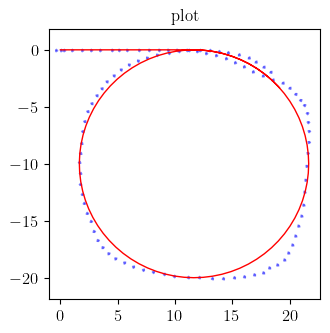

k 13
it: 014, loss: 0.919


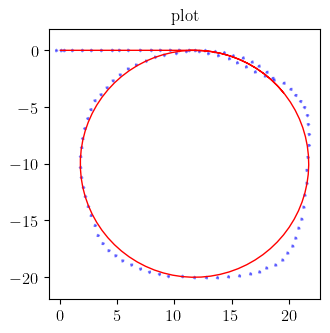

k 14
it: 015, loss: 0.885


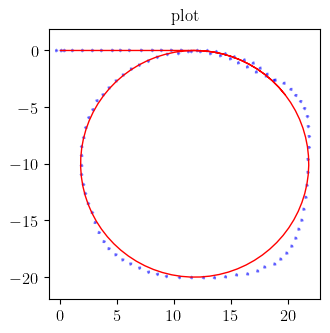

k 15
it: 016, loss: 0.855


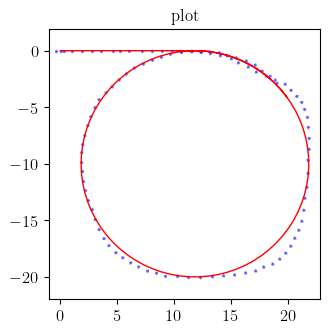

k 16
it: 017, loss: 0.852


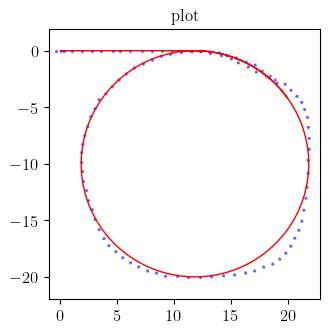

k 17
it: 018, loss: 0.829


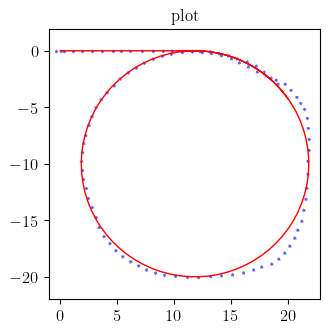

k 18
it: 019, loss: 0.829


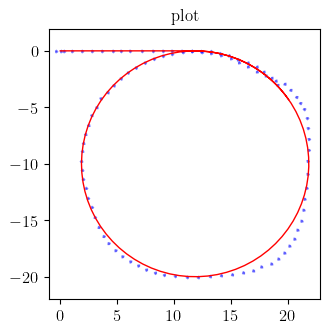

k 19
it: 020, loss: 0.825


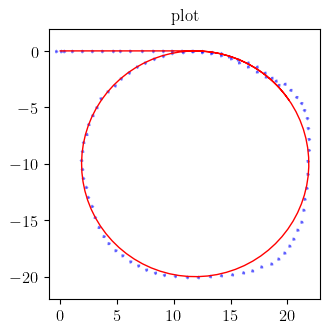

k 20
it: 021, loss: 0.790


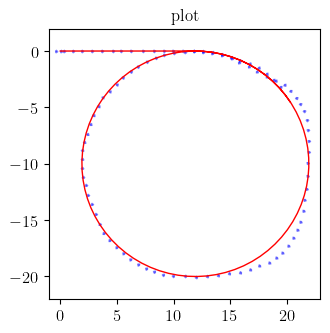

k 21
it: 022, loss: 0.779


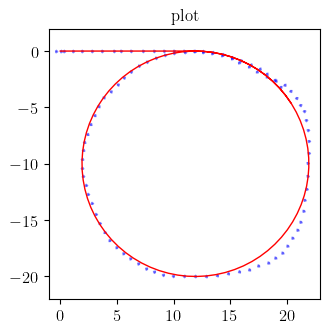

k 22
it: 023, loss: 0.774


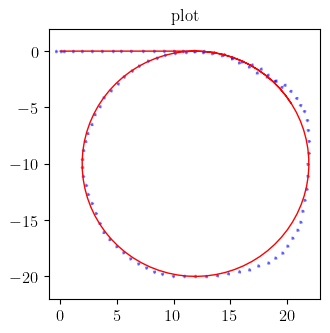

k 23
it: 024, loss: 0.770


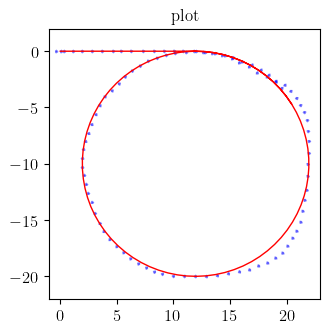

k 24
it: 025, loss: 0.763


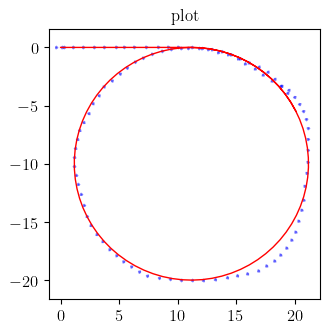

k 25
it: 026, loss: 0.751


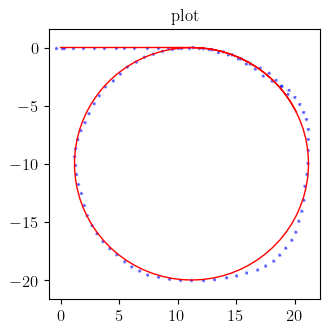

k 26
it: 027, loss: 0.752


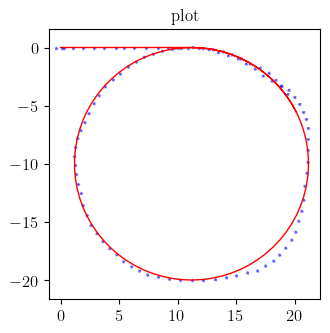

k 27
it: 028, loss: 0.747


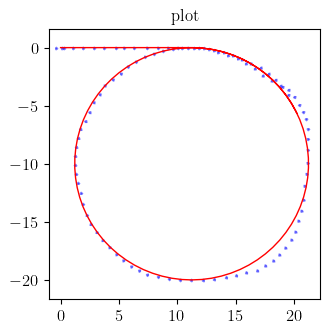

k 28
it: 029, loss: 0.748


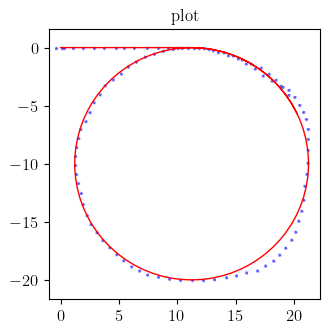

k 29
it: 030, loss: 0.741


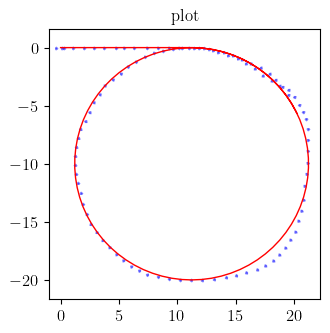

k 30
it: 031, loss: 0.740


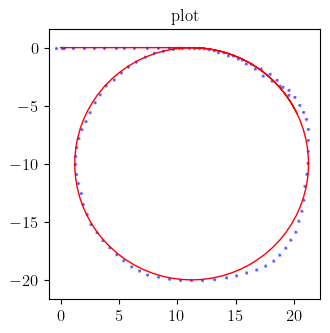

k 31
it: 032, loss: 0.730


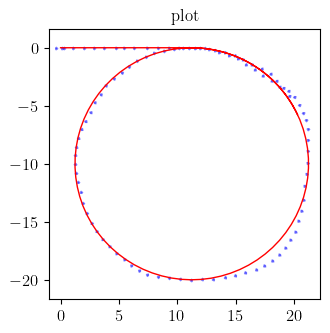

k 32
it: 033, loss: 0.720


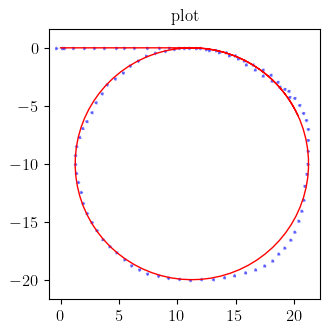

k 33
it: 034, loss: 0.714


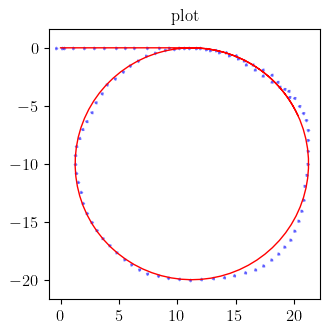

k 34
it: 035, loss: 0.711


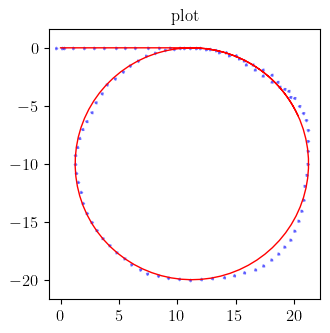

k 35
it: 036, loss: 0.706


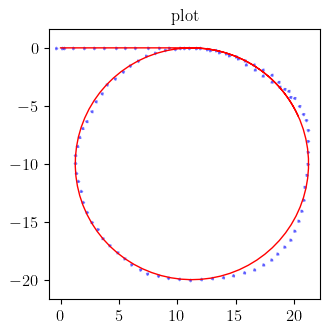

k 36
it: 037, loss: 0.703


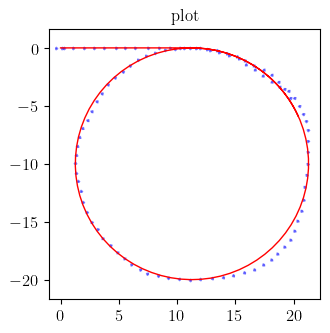

k 37
it: 038, loss: 0.701


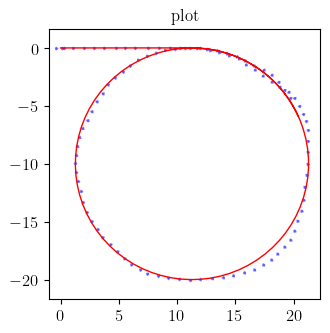

k 38
it: 039, loss: 0.700


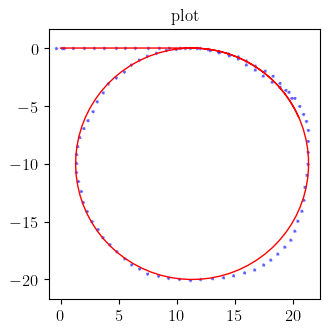

k 39
it: 040, loss: 0.699


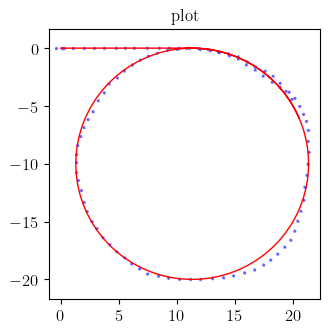

k 40
it: 041, loss: 0.690


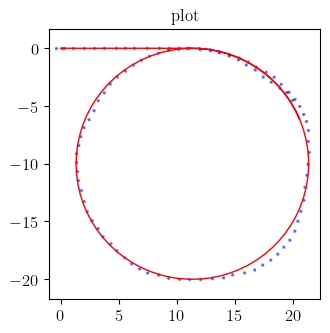

k 41
it: 042, loss: 0.692


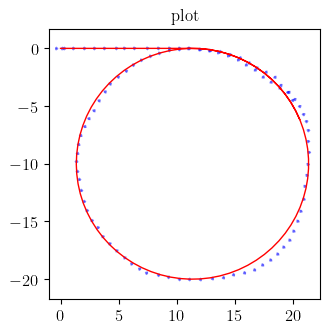

k 42
it: 043, loss: 0.692


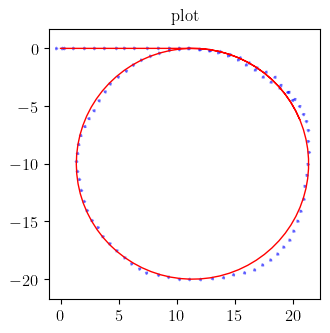

k 43
it: 044, loss: 0.693


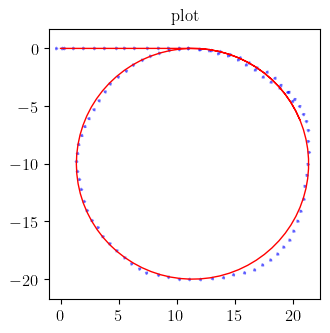

k 44
it: 045, loss: 0.692


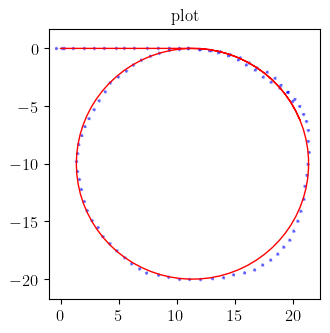

k 45
it: 046, loss: 0.692


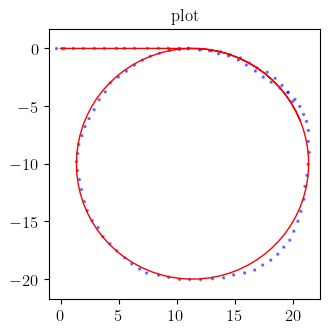

k 46
it: 047, loss: 0.688


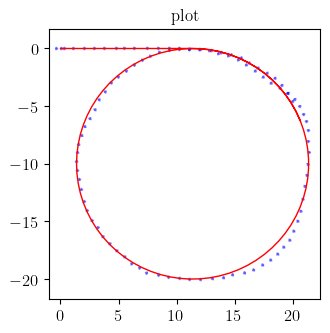

k 47
it: 048, loss: 0.689


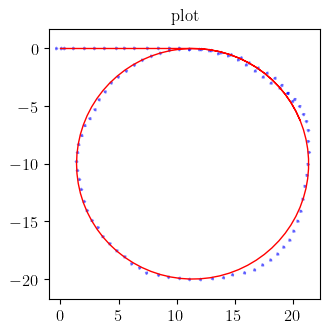

k 48
it: 049, loss: 0.688


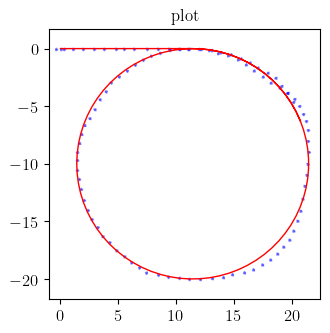

k 49
it: 050, loss: 0.686


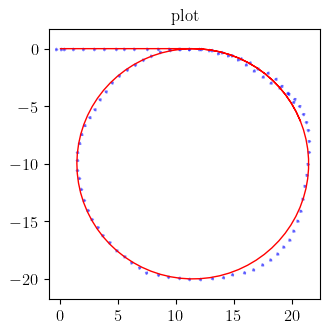

k 50
it: 051, loss: 0.686


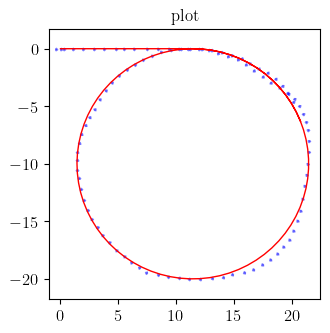

k 51
it: 052, loss: 0.683


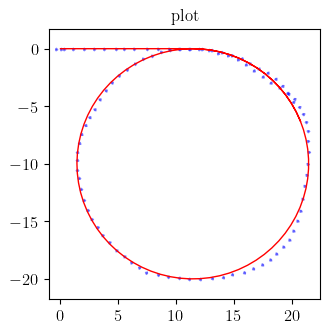

k 52
it: 053, loss: 0.679


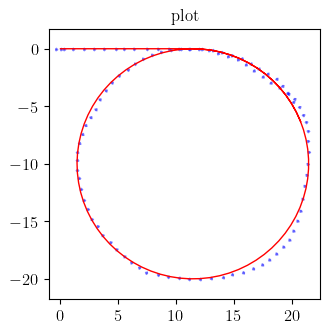

k 53
it: 054, loss: 0.679


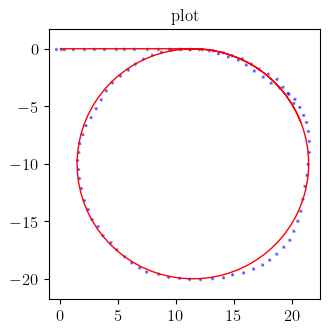

k 54
it: 055, loss: 0.669


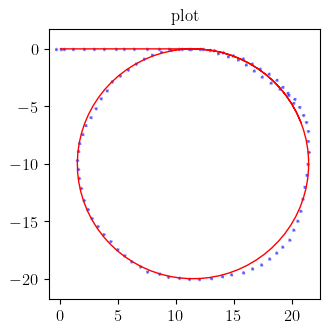

k 55
it: 056, loss: 0.666


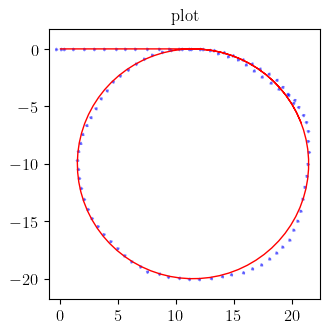

k 56
it: 057, loss: 0.665


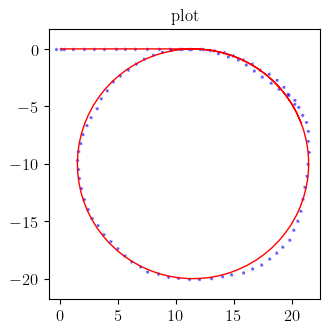

k 57
it: 058, loss: 0.664


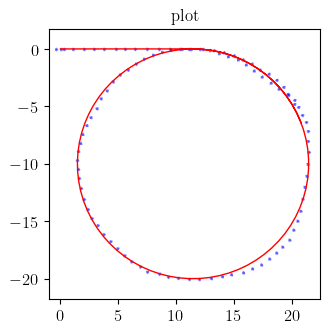

k 58
it: 059, loss: 0.663


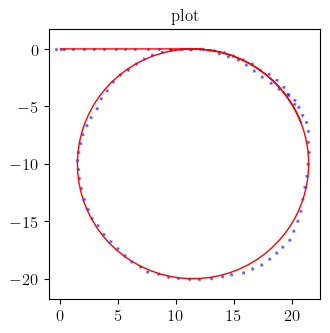

k 59
it: 060, loss: 0.663


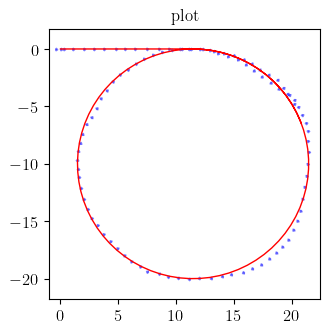

k 60
it: 061, loss: 0.664


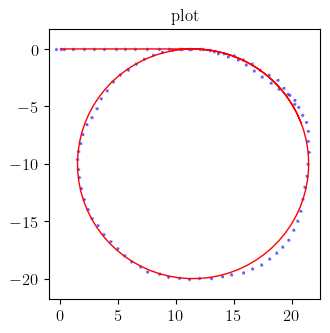

k 61
it: 062, loss: 0.663


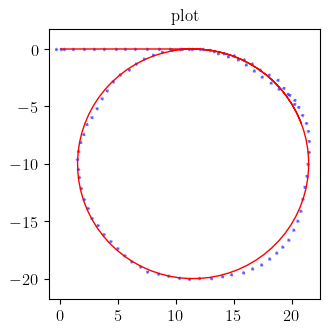

k 62
it: 063, loss: 0.663


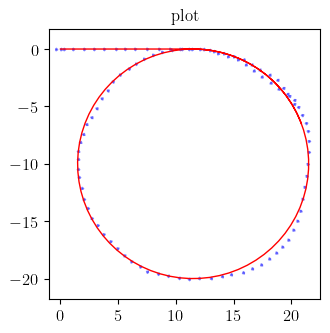

k 63
it: 064, loss: 0.663


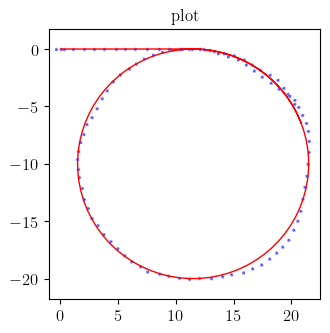

k 64
it: 065, loss: 0.660


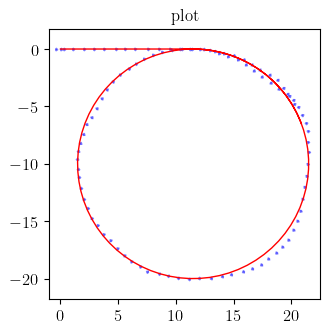

k 65
it: 066, loss: 0.659


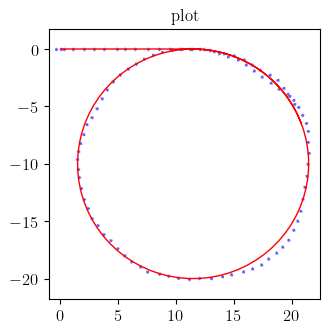

k 66
it: 067, loss: 0.660


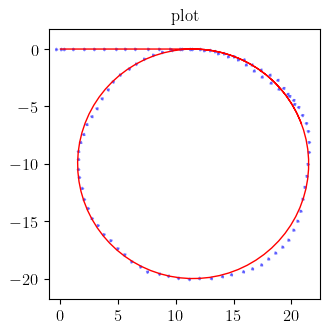

k 67
it: 068, loss: 0.660


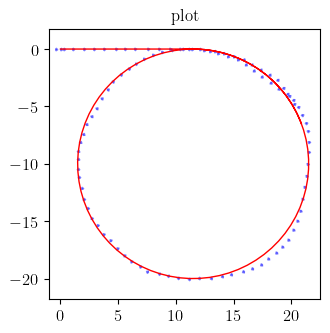

k 68
it: 069, loss: 0.661


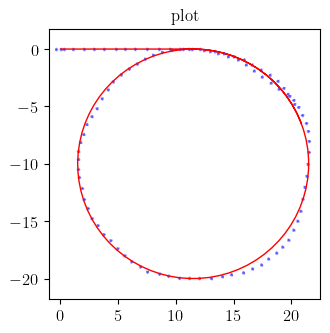

k 69
it: 070, loss: 0.661


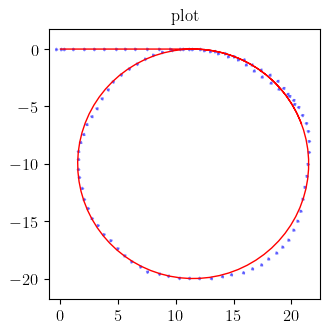

k 70
it: 071, loss: 0.659


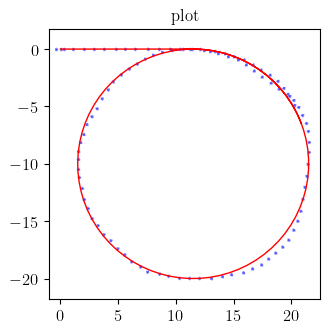

k 71
it: 072, loss: 0.658


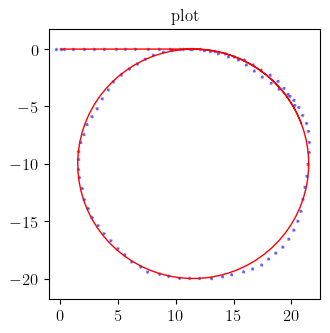

k 72
it: 073, loss: 0.659


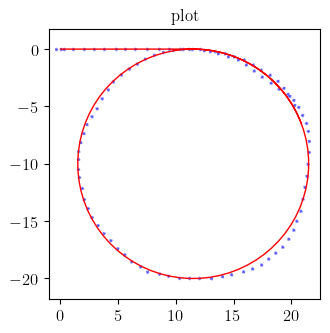

k 73
it: 074, loss: 0.656


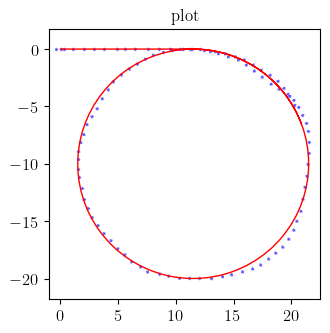

k 74
it: 075, loss: 0.655


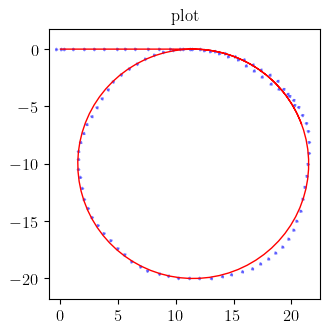

k 75
it: 076, loss: 0.655


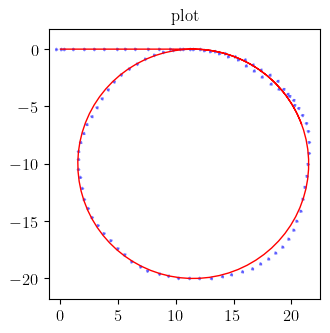

k 76
it: 077, loss: 0.655


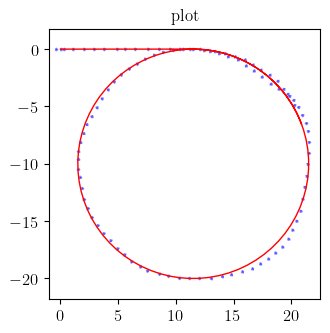

k 77
it: 078, loss: 0.655


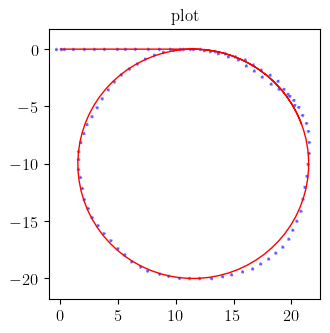

k 78
it: 079, loss: 0.654


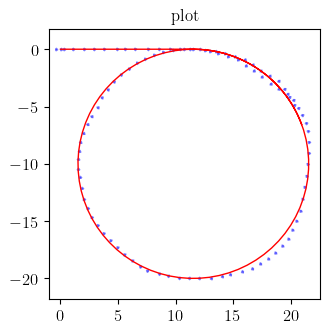

k 79
it: 080, loss: 0.655


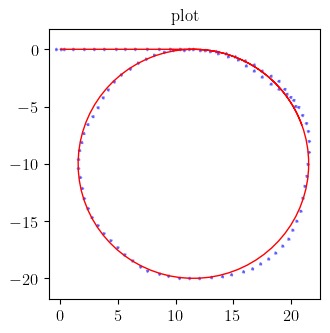

k 80
it: 081, loss: 0.654


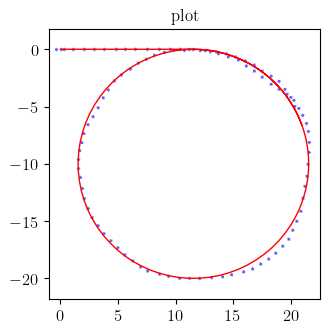

k 81
it: 082, loss: 0.654


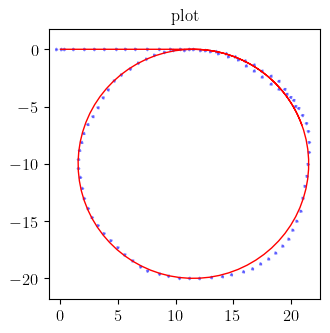

k 82
it: 083, loss: 0.654


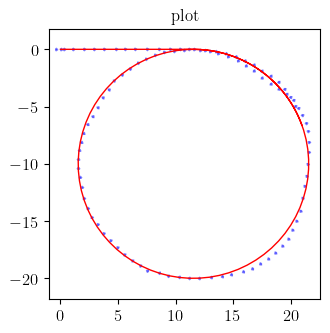

k 83
it: 084, loss: 0.654


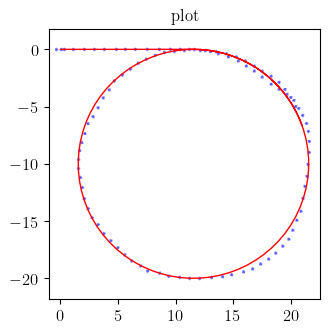

k 84
it: 085, loss: 0.654


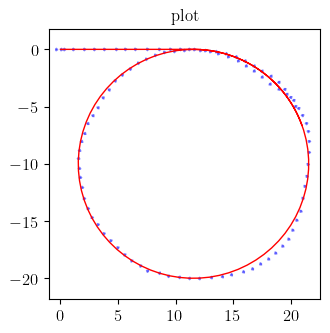

k 85
it: 086, loss: 0.654


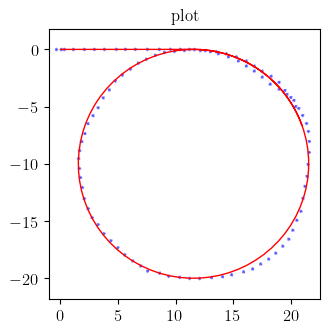

k 86
it: 087, loss: 0.655


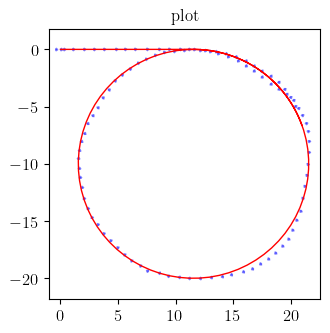

k 87
it: 088, loss: 0.652


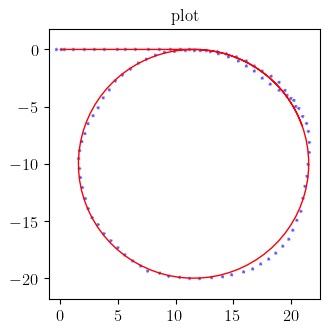

k 88
it: 089, loss: 0.653


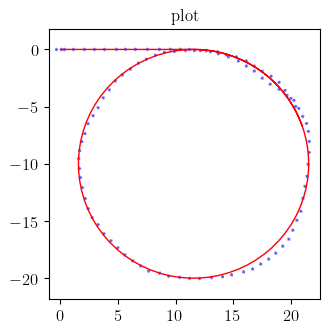

k 89
it: 090, loss: 0.652


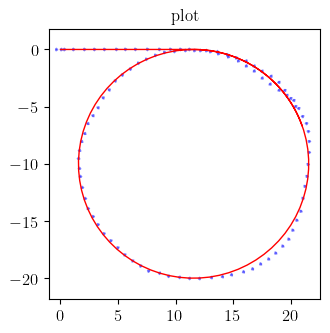

k 90
it: 091, loss: 0.652


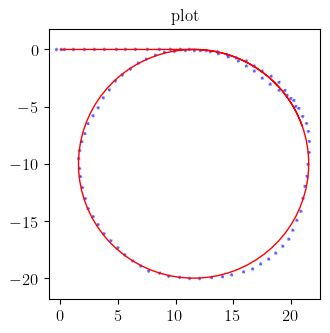

k 91
it: 092, loss: 0.651


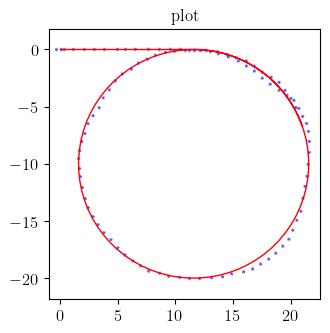

k 92
it: 093, loss: 0.652


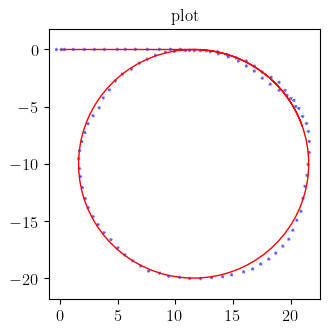

k 93
it: 094, loss: 0.651


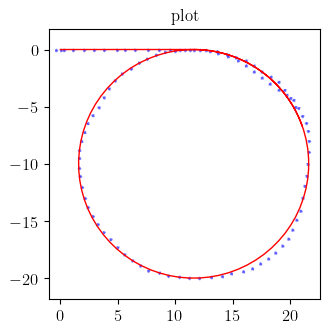

k 94
it: 095, loss: 0.648


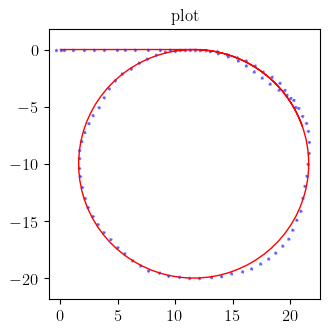

k 95
it: 096, loss: 0.648


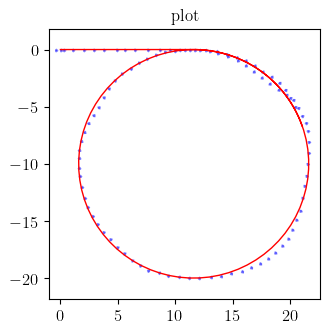

k 96
it: 097, loss: 0.646


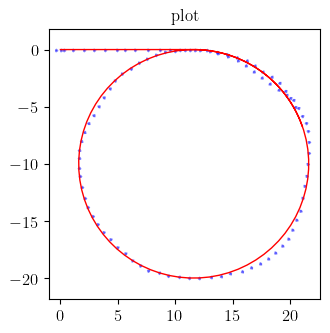

k 97
it: 098, loss: 0.646


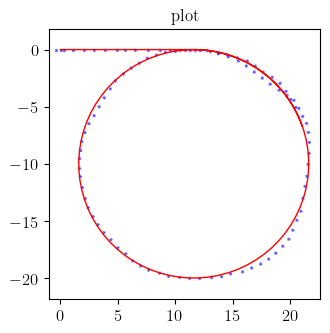

k 98
it: 099, loss: 0.645


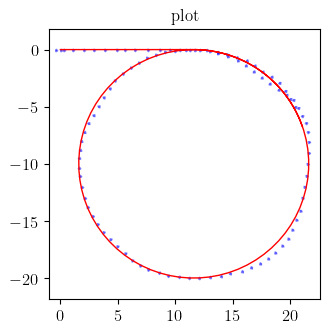

k 99
it: 100, loss: 0.644


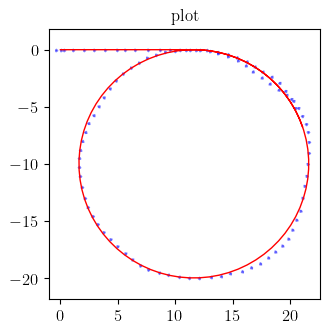

In [15]:
params = [P_sqrt, q]
opt = torch.optim.SGD(params, lr=.1)
losses = []

import shutil
import os
if os.path.exists('./figs'):
    shutil.rmtree('./figs')

os.mkdir('./figs')

for k in range(100):
    print("k", k)
    with torch.no_grad():
        test_loss, X, U = loss(100, 4, P_sqrt.detach(), q.detach(), seed=0)
        losses.append(test_loss)
        print("it: %03d, loss: %3.3f" % (k+1, test_loss.item()))
    opt.zero_grad()
    l, _, _ = loss(100, 1, P_sqrt, q, seed=k+1)
    plt.show()
    l.backward()
    torch.nn.utils.clip_grad_norm_(params, 10)
    opt.step()
    latexify(fig_width=3.5, fig_height=3.5)
    plot_path(X[:,0,:])
    plt.savefig("figs/vehicle_%03d.png" % (k+1))
    plt.show()
    plt.close()
    
#     break


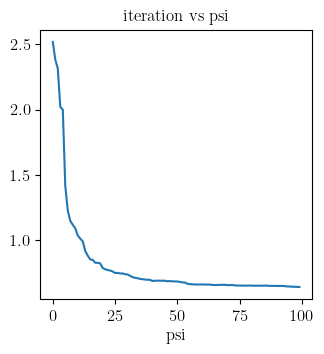

In [16]:
plt.plot(losses)
plt.title('iteration vs psi')
plt.xlabel('iteration')
plt.xlabel('psi')
plt.savefig('iteration_vs_psi.png')

In [ ]:
losses_monte_carlo_untrained, X_untrained, U_untrained = loss(
    100, 2, torch.eye(4), torch.zeros(4), seed=1000+k, f_func=f_batch2)

print(losses_monte_carlo_untrained)
# print(len(losses_monte_carlo_untrained))

plot_path(X_untrained[:,0,:], 'X_untrained on f_batch2: %.3f' % (losses_monte_carlo_untrained), kolor='g')

# plt.savefig('X_untrained_on_toploop.png')

losses_trained, X_trained, U_trained = loss(100, 2, P_sqrt, q, seed=1000+k, f_func=f_batch2)

print(losses_trained)
# print(len(losses_monte_carlo_untrained))

plot_path(X_trained[:,0,:], ' f_batch2: X_trained: %.3f, X_untrained: %.3f' % (
    losses_trained, 
    losses_monte_carlo_untrained))

plt.savefig('X_trained_on_toploop.png')

In [ ]:
losses_monte_carlo_untrained, X_untrained, U_untrained = loss(
    100, 2, torch.eye(4), torch.zeros(4), seed=1000+k, f_func=f_batch3)

print(losses_monte_carlo_untrained)
# print(len(losses_monte_carlo_untrained))

plot_path(X_untrained[:,0,:], 'X_untrained on f_batch2: %.3f' % (losses_monte_carlo_untrained), kolor='g')

# plt.savefig('X_untrained_on_toploop.png')

losses_trained, X_trained, U_trained = loss(100, 2, P_sqrt, q, seed=1000+k, f_func=f_batch3)

print(losses_trained)
# print(len(losses_monte_carlo_untrained))

plot_path(X_trained[:,0,:], ' f_batch3: X_trained: %.3f, X_untrained: %.3f' % (
    losses_trained, 
    losses_monte_carlo_untrained))

plt.savefig('X_trained_on_straight.png')

tensor(38.1962)
100
100
tensor(0.6273, grad_fn=<AddBackward0>)


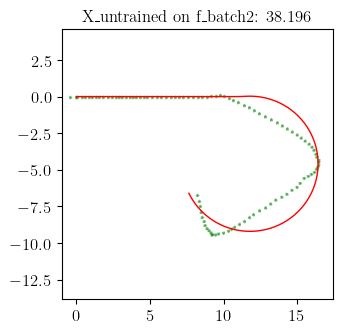

In [23]:
q1, v1, _ = loss(
    100, 2, torch.eye(4), torch.zeros(4), seed=1000+k, f_func=f_batch0)

print(q1)
# print(len(losses_monte_carlo_untrained))

plot_path(v1[:,0,:], 'X_untrained on f_batch2: %.3f' % (q1), kolor='g')

# plt.savefig('X_untrained_on_toploop.png')

# q2, v2, _ = loss(100, 2, P_sqrt, q, seed=1000+k, f_func=f_batch0)

print(len(v2))


print(len(v1))

print(q2)
# print(len(losses_monte_carlo_untrained))

# plot_path(v2[:,0,:], ' f_batch3: X_trained: %.3f, X_untrained: %.3f' % (
#     0.0, 
#     q1))

plt.savefig('X_trained_on_randomwalk.png')

In [ ]:
losses_monte_carlo_trained = [loss(100, 1, P_sqrt.detach(), q.detach(), seed=1000+k)[0] for k in range(100)]

In [ ]:
import matplotlib
latexify(fig_width=4)
plt.hist(losses_monte_carlo_untrained, bins=30, alpha=.5, label='untrained', color='tab:blue')
plt.hist(losses_monte_carlo_trained, bins=30, alpha=.5, label='trained', color='tab:orange')
plt.axvline(np.mean(losses_monte_carlo_untrained), color='tab:blue')
plt.axvline(np.mean(losses_monte_carlo_trained), color='tab:orange')
plt.xscale('log')
plt.legend()
plt.xlabel('cost')
plt.ylabel('count')
plt.xlim(.3, 20)
plt.subplots_adjust(bottom=.2)
plt.savefig('vehicle_hist.pdf')
plt.show()

In [ ]:
np.mean(losses_monte_carlo_untrained)

In [ ]:
np.mean(losses_monte_carlo_trained)

In [ ]:
P_sqrt.t() @ P_sqrt

In [ ]:
q

In [ ]:
for i in range(3):
    plt.title((["e", "dpsi", "v"])[i])
    plt.plot(np.array(X)[:, 0, i])
    plt.show()

In [ ]:
for i in range(2):
    plt.title((["a", "z"])[i])
    plt.plot(np.array(U)[:, 0, i])
    plt.show()